<a href="https://colab.research.google.com/github/kla55/Pytorch_learning/blob/main/Pytorch_youtube/FreeCodeAcademy/05_PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [68]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [71]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [72]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [73]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79e066bde710>,
 ['pizza', 'steak', 'sushi'])

In [74]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

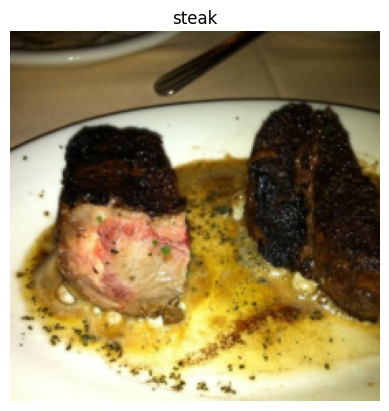

In [75]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [76]:
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [77]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

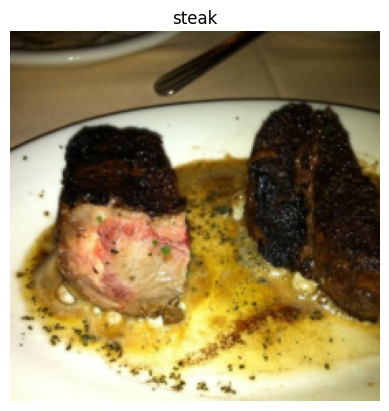

In [78]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

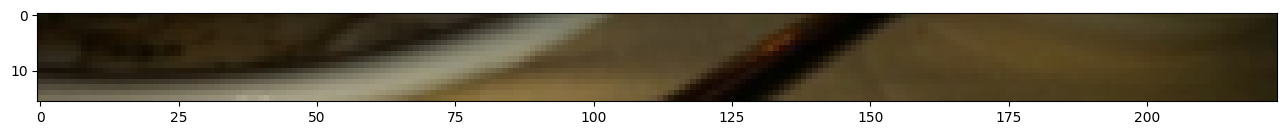

In [79]:
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


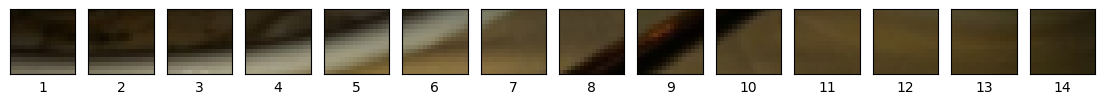

In [80]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


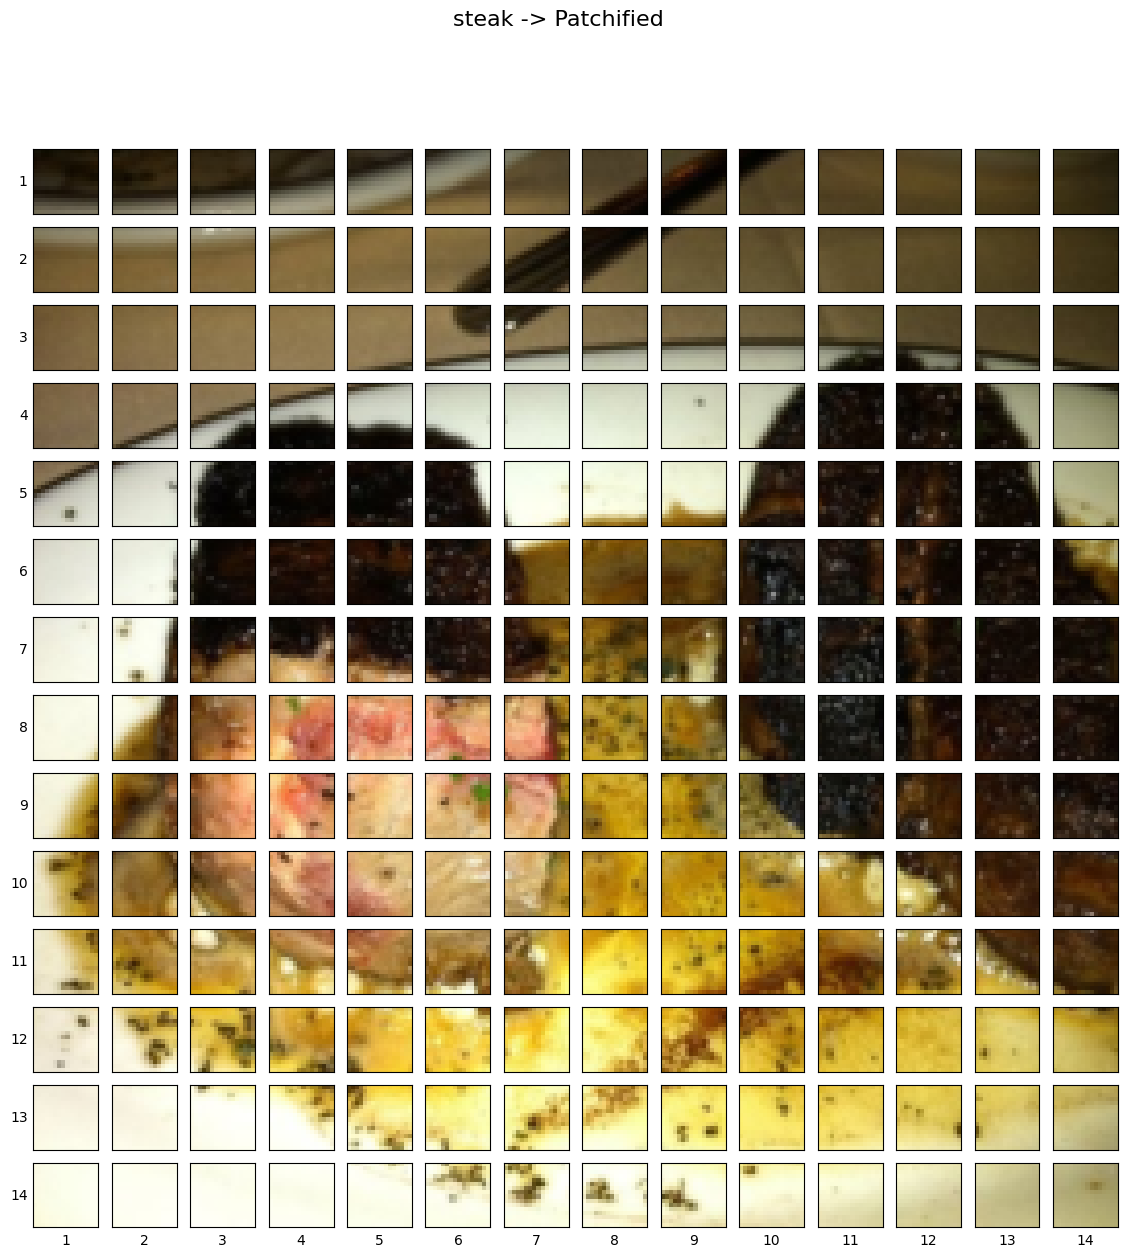

In [81]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [82]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

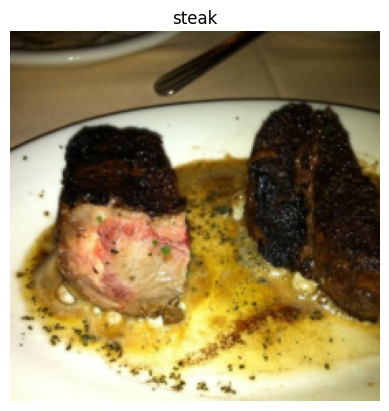

In [83]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [84]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image.shape)
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [374, 559, 426, 266, 530]


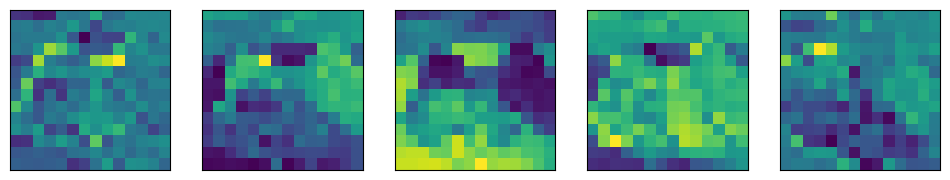

In [85]:
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [86]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [87]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0653,  0.0876,  0.1135,  0.1888,  0.1181, -0.0062,  0.1518,
           -0.0182,  0.1115,  0.0353,  0.0620,  0.0579,  0.0572,  0.0379],
          [ 0.1557,  0.1713,  0.2151,  0.1603,  0.1218,  0.0967,  0.0567,
            0.1396,  0.0765,  0.0960,  0.0775,  0.0632,  0.0535,  0.0341],
          [ 0.1325,  0.1364,  0.1446,  0.1508,  0.1184,  0.2163,  0.1207,
            0.1138,  0.1894,  0.2043, -0.0040,  0.0644,  0.0702,  0.0230],
          [ 0.1391,  0.1611,  0.0501, -0.0308, -0.1205,  0.1758,  0.2727,
            0.2665,  0.2832, -0.1083,  0.0184,  0.0145,  0.1201,  0.1382],
          [ 0.3180,  0.2220,  0.1179, -0.0144,  0.0315,  0.1725,  0.3256,
            0.2525,  0.2316,  0.1141,  0.0556,  0.0163,  0.0137,  0.2040],
          [ 0.2953,  0.2566,  0.0294, -0.0161,  0.0244, -0.0230,  0.2792,
            0.0882,  0.0983,  0.0054,  0.0180,  0.0504, -0.0239,  0.0637],
          [ 0.3125,  0.0387,  0.1885,  0.3175,  0.1499,  0.0149,  0.1601,
            0.0898,  0.1057,  0.

In [88]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [89]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [90]:
set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

In [91]:
image.unsqueeze(0)

tensor([[[[0.0824, 0.0863, 0.0627,  ..., 0.1843, 0.1647, 0.1569],
          [0.0824, 0.0863, 0.0706,  ..., 0.1529, 0.1373, 0.1294],
          [0.0824, 0.0941, 0.0863,  ..., 0.1451, 0.1373, 0.1333],
          ...,
          [0.9843, 0.9843, 0.9922,  ..., 0.6902, 0.6863, 0.6824],
          [0.9843, 0.9843, 0.9922,  ..., 0.6980, 0.6941, 0.6902],
          [0.9843, 0.9804, 0.9843,  ..., 0.7059, 0.7020, 0.6941]],

         [[0.0745, 0.0784, 0.0549,  ..., 0.1569, 0.1451, 0.1373],
          [0.0588, 0.0667, 0.0471,  ..., 0.1255, 0.1176, 0.1098],
          [0.0471, 0.0588, 0.0549,  ..., 0.1176, 0.1137, 0.1137],
          ...,
          [0.9804, 0.9804, 0.9882,  ..., 0.6667, 0.6588, 0.6549],
          [0.9804, 0.9804, 0.9882,  ..., 0.6745, 0.6706, 0.6667],
          [0.9725, 0.9765, 0.9804,  ..., 0.6824, 0.6784, 0.6706]],

         [[0.0275, 0.0314, 0.0078,  ..., 0.0863, 0.0706, 0.0627],
          [0.0196, 0.0235, 0.0039,  ..., 0.0549, 0.0431, 0.0353],
          [0.0118, 0.0196, 0.0118,  ..., 0

In [92]:
patch_embedded_image = patchify(image.unsqueeze(0))

In [93]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [94]:
image.shape[-1]

224

In [95]:
224/ 16

14.0

In [96]:
16 * 16 * 3

768

In [97]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

In [98]:
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [99]:
print(patch_embedded_image.shape)


torch.Size([1, 196, 768])


In [100]:
batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]

In [101]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimensions,
                                      requires_grad=True))

In [102]:
print(class_token[:, :, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [103]:
class_token.shape

torch.Size([1, 1, 768])

In [104]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

In [105]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [106]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1952,  0.0514, -0.2195,  ...,  0.1422, -0.0478,  0.0960],
         [-0.2406,  0.0669, -0.2172,  ...,  0.1616, -0.0699,  0.0741],
         ...,
         [-0.8758,  0.1887, -0.1667,  ...,  0.6203, -0.4579,  0.3088],
         [-0.7326,  0.1504, -0.1842,  ...,  0.5617, -0.4006,  0.2795],
         [-0.5911,  0.1154, -0.2173,  ...,  0.4853, -0.3428,  0.3153]]],
       grad_fn=<CatBackward0>)

In [107]:
16**2 * 3

768

In [108]:
number_of_patches

196

In [109]:
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
embedding_dimension

768

In [110]:
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

In [111]:
print(position_embedding[:, :10, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [112]:
position_embedding.shape

torch.Size([1, 197, 768])

In [113]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8048, 1.0514, 0.7805,  ..., 1.1422, 0.9522, 1.0960],
         [0.7594, 1.0669, 0.7828,  ..., 1.1616, 0.9301, 1.0741],
         ...,
         [0.1242, 1.1887, 0.8333,  ..., 1.6203, 0.5421, 1.3088],
         [0.2674, 1.1504, 0.8158,  ..., 1.5617, 0.5994, 1.2795],
         [0.4089, 1.1154, 0.7827,  ..., 1.4853, 0.6572, 1.3153]]],
       grad_fn=<AddBackward0>)


In [114]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [115]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [116]:
# Summary

set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,
                                      1,
                                      embedding_dimensions),
                                      requires_grad = True)
print(class_token.shape)

patch_embedding_class_token = torch.cat((class_token, patch_embedded_image), dim = 1)
print(patch_embedding_class_token.shape)


number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [140]:
class MultiheadSelfAttentionBlock(nn.Module):

  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               attn_dropout: float = 0):

    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)

    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [141]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dims=768, # from Table 1
                                                             num_heads=12) # from Table 1
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(patch_and_position_embedding.shape)
print(patched_image_through_msa_block.shape)

TypeError: ignored

In [142]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):

    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
               nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
               nn.GELU(),
               nn.Dropout(p=dropout),
               nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
               nn.Dropout(p=dropout)
               )

  def forward(self, x):
      x = self.layer_norm(x)
      x = self.mlp(x)
      return x

In [143]:
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(patched_image_through_msa_block.shape)
print(patched_image_through_mlp_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [152]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
                embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                num_heads:int=12, # Heads from Table 1 for ViT-Base
                mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                attn_dropout:float=0):

    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x

    x = self.mlp_block(x) + x

    return x



In [153]:
transformer_encoder_block = TransformerEncoderBlock()


In [154]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [155]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [156]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [121]:
Pytorch_youtube/FreeCodeAcademy/05_PyTorch_Paper_Replicating.ipynb

SyntaxError: ignored